In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
max_date = max_date[0]

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.datetime.strptime(max_date, "%Y-%m-%d") - dt.timedelta(days=365)

In [11]:
# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(query,columns=['date', 'precipitation'])
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'], format='%Y-%m-%d')
precipitation_df.set_index('date', inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date',ascending=True)

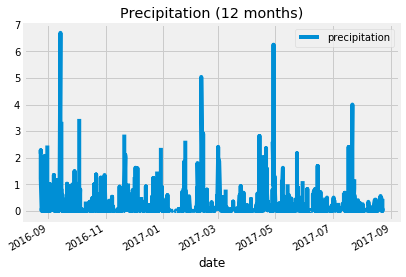

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(title="Precipitation (12 months)")
plt.legend(loc='best')
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data 
precipitation_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [15]:
# Design a query to show how many stations are available in this dataset?

# How many stations are available in this dataset?
available_stations = session.query(Measurement.station).distinct().count()
print(f"Stations Available: {available_stations} ")

Stations Available: 9 


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
 
active_stations = session.query(Measurement.station, 
                                func.count(Measurement.station)).group_by(Measurement.station).order_by(
                                func.count(Measurement.station).desc()).all()
print(f"Most Active Stations")
active_stations

Most Active Stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

most_active_station=active_stations[0][0]
print(f"Most Active Station: {most_active_station}")

Most Active Station: USC00519281


In [18]:
# Choose the station with the highest number of temperature observations.
most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
    func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
print(f"Most Active Station Temperatures")
print(f"Low: {most_active_temps[0][0]} High: {most_active_temps[0][1]} Average: {round(most_active_temps[0][2], 1)}")

Most Active Station Temperatures
Low: 54.0 High: 85.0 Average: 71.7


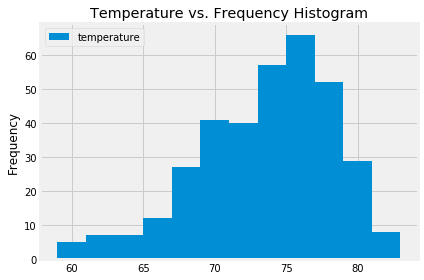

In [19]:
most_temps_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_temps_station= most_temps_station[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperature_observations = session.query( Measurement.tobs).filter(Measurement.date >= year_ago).filter(Measurement.station == most_temps_station).all()
temperature_observations = pd.DataFrame(temperature_observations, columns=['temperature'])
temperature_observations.plot.hist(bins=12, title="Temperature vs. Frequency Histogram")
plt.tight_layout()
plt.show()


# Step 2 - Climate App

In [20]:
# Design a Flask API based on the queries that you have just developed
# Use Flask to create your routes per instructions

from flask import Flask, jsonify